In [1]:
import os
import io
import zipfile
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from pyproj import Proj, transform

from sklearn import preprocessing
from sklearn.cluster import KMeans

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

pd.set_option('display.max_columns', 500)
style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6

In [29]:
def clean(df, col='eui', use_log=True, nonneg=False, nstd=2, onesided=None):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    onesided = nonneg if onesided is None else onesided
    try:
        if nonneg:
            df = df[df[col] >= 0]
        if use_log:
            df = df[df[col] != 0]
            vals = np.log10(df[col].astype(float))
        else:
            vals = df[col].astype(float)
    except ValueError:
        return df
    
    if nstd:
        vals_centered = vals - np.mean(vals)
        if not onesided:
            vals_centered = np.abs(vals_centered)
        return df[ vals_centered < nstd*np.std(vals) ]
    return df

def p(a):
    print(a)
    return a

In [3]:
years = map(str, [2013, 2014, 2015, 2016])
eui_cols = ['EUI_{}'.format(y) for y in years]

ll84_urls = {
    '2016': "http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
    '2015': "http://www.nyc.gov/html/gbee/downloads/excel/2015_nyc_cy2014__ll84_disclosure_data.xlsx",
    '2014': "http://www.nyc.gov/html/gbee/downloads/excel/150428_2014_nyc_ll84_disclosure.xlsx",
    '2013': "http://www.nyc.gov/html/gbee/downloads/excel/2013_nyc_ll84_disclosure.xlsx",
#     '2012': "http://www.nyc.gov/html/gbee/downloads/excel/2012_nyc_cy2011_ll84_disclosure_data.xls"
}

PLUTO_cache = 'data/pluto16.csv'
PLUTO_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'

In [32]:
if os.path.isfile(PLUTO_cache):
    # Read from cache
    df_pluto = pd.read_csv(PLUTO_cache)
else:
    print('Downloading...')
    
    remotezip = urllib.urlopen(PLUTO_url).read()
    with zipfile.ZipFile(io.BytesIO(remotezip)) as z:
        df_pluto = pd.concat([
            pd.read_csv(z.open(p(f)))
            for f in z.namelist()
            if os.path.splitext(f)[1] == '.csv'
        ])
    
    df_pluto.to_csv(PLUTO_cache, index=False)
    
df_pluto = df_pluto[['BBL', 'Borough','LotArea', 'BldgArea', 'ComArea', 'ResArea', 
                     'OfficeArea', 'RetailArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 
                     'YearBuilt', 'XCoord', 'YCoord', 'ZipCode', 'Address']]
    
print(df_pluto.shape)
df_pluto.head()

(858370, 16)


,BBL,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,3.000010e+09,BK,151930,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JOHN STREET
1,3.000010e+09,BK,19682,154400,154400,0,17160,0,9.0,0,90,1920,987838.0,195989.0,11201.0,10 JAY STREET
2,3.000018e+09,BK,0,102534,4686,97848,0,4686,12.0,42,44,0,987624.0,195992.0,11201.0,1 JOHN STREET
3,3.000030e+09,BK,387060,0,0,0,0,0,0.0,0,0,0,988568.0,196151.0,11201.0,JAY STREET
4,3.000030e+09,BK,6384,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JAY STREET


In [5]:
dfs_ll84 = {}
for year, url in ll84_urls.items():
    local_fname = 'data/LL84_{}.csv'.format(year)
    if os.path.isfile(local_fname):
        dfs_ll84[year] = pd.read_csv(local_fname)
    else:
        dfs_ll84[year] = pd.read_excel(url)
        dfs_ll84[year].to_csv(local_fname, encoding='utf-8')
dfs_ll84.keys()

['2015', '2014', '2016', '2013']

In [6]:
dfs_ll84['2016'].columns

Index([u'Unnamed: 0', u'Record Number', u'Order',
       u'NYC Borough, Block and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft²)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft²)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft²)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft²)',
  

In [7]:
# Keep BBL, Energy, and Floor Data

keepCol = ['BBL', 'Site EUI\n(kBtu/ft2)', 'Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2013'] = dfs_ll84['2013'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2013', 'floorArea_2013'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)', 
           'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2014'] = dfs_ll84['2014'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2014', 'floorArea_2014'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)',
          'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2015'] = dfs_ll84['2015'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2015', 'floorArea_2015'])))

keepCol = ['NYC Borough, Block and Lot (BBL)', r'Site EUI (kBtu/ft²)', r'DOF Property Floor Area (ft²)',
          'Primary Property Type - Self Selected']
dfs_ll84['2016'] = dfs_ll84['2016'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2016', 'floorArea_2016','TYPE_2016'])))

In [17]:
df84 = reduce(
    lambda df1, df2: df1.merge(df2, left_on='BBL', right_on='BBL', how='inner'),
    [dfs_ll84[year] for year in years]
)
print(df84.values.shape)
df84.head()

(15518, 10)


,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,TYPE_2016
0,1000047501,102.0,2428325.0,92.5,2621563.0,149,2542563.0,133.8,2542563.0,Office
1,1000057501,119.6,1338000.0,134.5,1354691.0,113.8,1354691.0,135.8,1354691.0,Office
2,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL
3,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL
4,1000090001,99.5,852840.0,78.5,845018.0,81.3,845018.0,71.4,845018.0,Office


In [18]:
df_types = df84[['TYPE_2016', 'BBL']].groupby('TYPE_2016').count()
df_types[df_types.BBL > 50].sort_values('BBL', ascending=False)

,BBL
TYPE_2016,
Multifamily Housing,10924
Office,1275
See Primary BBL,480
College/University,301
Hotel,230
Non-Refrigerated Warehouse,175
Mixed Use Property,138
Other,125
Retail Store,123


In [36]:
df = df84.merge(df_pluto, on='BBL', how='inner')
print(df.values.shape)
df.head()

(15507, 25)


,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,TYPE_2016,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,1000047501,102.0,2428325.0,92.5,2621563.0,149,2542563.0,133.8,2542563.0,Office,MN,111382,1888126,1888126,0,1848626,39500,50.0,0,52,1969,980917.0,195090.0,10004.0,1 WATER STREET
1,1000057501,119.6,1338000.0,134.5,1354691.0,113.8,1354691.0,135.8,1354691.0,Office,MN,54023,1024229,1024229,0,1024229,0,40.0,0,7,1970,981309.0,195131.0,10004.0,125 BROAD STREET
2,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL,MN,258600,458591,620,457971,0,620,6.0,586,590,1948,991053.0,202591.0,10009.0,134 AVENUE D
3,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,See Primary BBL,MN,258600,458591,620,457971,0,620,6.0,586,590,1948,991053.0,202591.0,10009.0,134 AVENUE D
4,1000090001,99.5,852840.0,78.5,845018.0,81.3,845018.0,71.4,845018.0,Office,MN,29481,845018,845018,0,839651,5367,32.0,0,9,1970,980562.0,195311.0,10004.0,34 WHITEHALL STREET


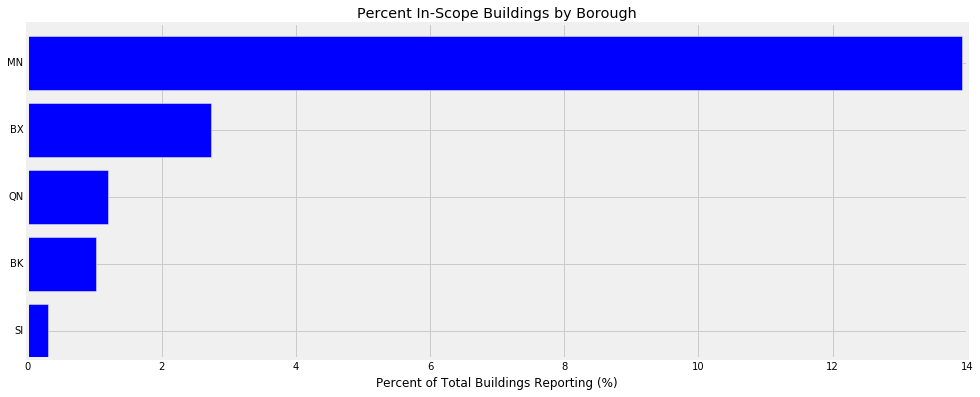

In [59]:
prop = (df.groupby('Borough').count()['ZipCode'] / df_pluto.groupby('Borough').count()['ZipCode']).sort_values()
xprop = np.arange(len(prop))
plt.barh(xprop, prop.values * 100., color='blue')
plt.title('Percent In-Scope Buildings by Borough')
plt.xlabel('Percent of Total Buildings Reporting (%)')
plt.yticks(xprop + 0.4, prop.index);

In [60]:
for col in eui_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(df[eui_cols].dtypes)

dfnan = df[eui_cols][np.any(np.isnan(df[eui_cols]), axis=1)]
print(dfnan.values.shape)
dfnan.head()

EUI_2013    float64
EUI_2014    float64
EUI_2015    float64
EUI_2016    float64
dtype: object
(5529, 4)


,EUI_2013,EUI_2014,EUI_2015,EUI_2016
2,30.3,NaN,NaN,NaN
3,30.3,NaN,NaN,NaN
7,39.8,NaN,25896.9,17938.1
10,52.6,58.9,NaN,60.9
18,49.7,NaN,66.9,62.3


In [61]:
print(df.shape)
df = df.dropna()
print(df.shape)

(15507, 25)
(9852, 25)


In [62]:
df['Longitude'], df['Latitude'] = transform(
    Proj(init='epsg:2263', preserve_units=True), # ny/li projection
    Proj(init='epsg:4326'), # wgs84 projection
    df.XCoord.values, df.YCoord.values# x, y
)

df[['Address', 'Latitude', 'Longitude']].head()

,Address,Latitude,Longitude
0,1 WATER STREET,40.702153,-74.012021
1,125 BROAD STREET,40.702266,-74.010607
4,34 WHITEHALL STREET,40.702760,-74.013301
5,17 STATE STREET,40.702891,-74.013878
6,24 WHITEHALL STREET,40.703347,-74.013730


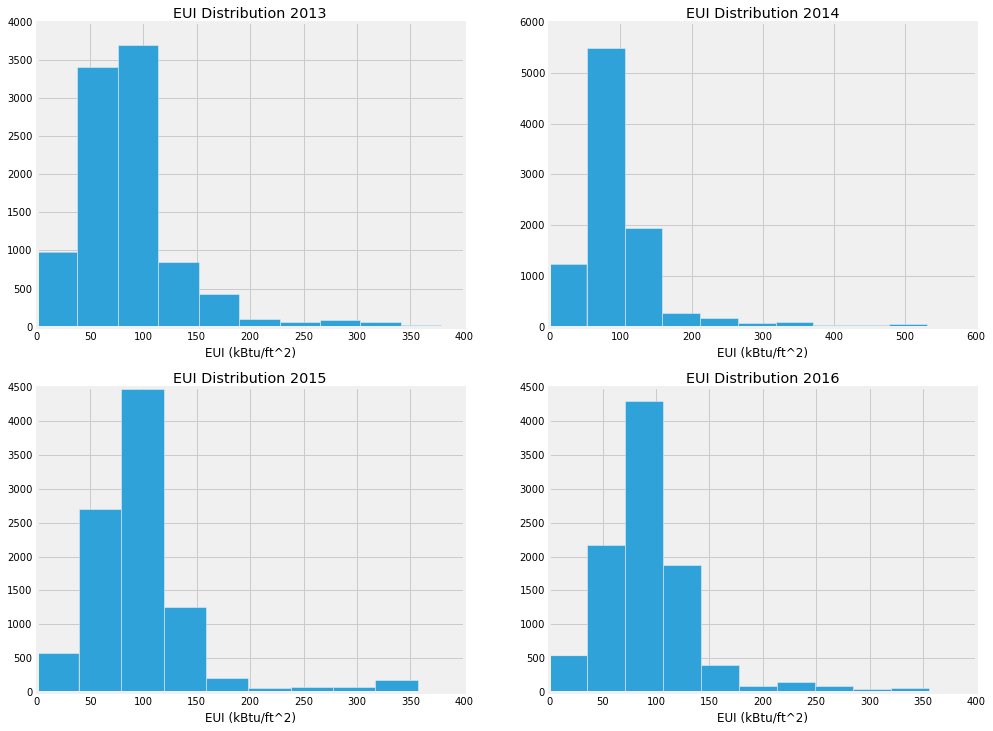

In [63]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(eui_cols, 1):
    plt.subplot(2,2,i)
    plt.title(col.replace('_', ' Distribution '))
    plt.xlabel('EUI (kBtu/ft^2)')
    plt.hist(clean(df, col, nonneg=True)[col])

In [64]:
# remove outliers for all eui columns and get description. doesn't update df
reduce(lambda df, col: clean(df, col), eui_cols, df)[eui_cols].describe()

,EUI_2013,EUI_2014,EUI_2015,EUI_2016
count,7996.000000,7996.000000,7996.000000,7996.000000
mean,84.000200,92.196598,95.732966,91.517834
std,33.950801,35.009147,33.169024,31.917395
min,15.600000,22.200000,30.700000,30.500000
25%,64.200000,71.675000,74.575000,70.800000
50%,79.900000,87.450000,89.800000,86.300000
75%,98.325000,107.500000,110.700000,106.400000
max,375.900000,361.400000,278.000000,246.500000


In [65]:
df.to_csv('merged-w-latlon.csv', index=False)

## Add further data processing...

In [66]:
def makeCorrPlots(x, y, df, log=False):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    try:
        tmp = df[[x,y]]
        tmp = tmp.dropna()
        X, Y = tmp[x].astype(float), tmp[y].astype(float)
    except:
        print(x, y)
        return
    
    if not len(X) or not len(Y):
        return
    
    if log:
        X[X == 0] = 1e-12;
        X = np.log10(X)
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color='b', alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('{} v. {}{} (corr= {:.2f})'.format(y, 'log ' if log else '', x, np.corrcoef(X, Y)[0][1]))

In [69]:
eui_cols = {col for col in df.columns if 'eui' in col.lower()}
non_eui_cols = set(df.columns) - eui_cols
eui_cols, non_eui_cols = list(eui_cols), list(non_eui_cols)

plot_cols = 'LotArea	BldgArea	ComArea	ResArea	OfficeArea	RetailArea	NumFloors	UnitsRes	UnitsTotal'.split('\t')

In [74]:
df2 = pd.concat([
    df[plot_cols + ['EUI_{}'.format(y), 'floorArea_{}'.format(y)]].rename(columns={
        'EUI_{}'.format(y): 'EUI',
        'floorArea_{}'.format(y): 'floorArea'
    })
    for y in years
])

if df2.EUI.dtype != float:
    df2 = df2[df2.EUI != 'Not Available']
df2.EUI = pd.to_numeric(df2.EUI)

print(df2.dtypes)
df2.head()

LotArea         int64
BldgArea        int64
ComArea         int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumFloors     float64
UnitsRes        int64
UnitsTotal      int64
EUI           float64
floorArea     float64
dtype: object


,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,EUI,floorArea
0,111382,1888126,1888126,0,1848626,39500,50.0,0,52,102.0,2428325.0
1,54023,1024229,1024229,0,1024229,0,40.0,0,7,119.6,1338000.0
4,29481,845018,845018,0,839651,5367,32.0,0,9,99.5,852840.0
5,23080,544015,544015,0,542515,0,42.0,0,0,79.7,574095.0
6,39985,896956,896956,0,864078,2878,35.0,0,9,139.4,859807.0


In [75]:
for col in plot_cols:
    df = clean(df, col, nstd=0, nonneg=True)
    df2 = clean(df2, col, nstd=0, nonneg=True)
    
for col in eui_cols:
    df = clean(df, col, nstd=4, nonneg=True)
df2 = clean(df2, 'EUI', nstd=4, nonneg=True)

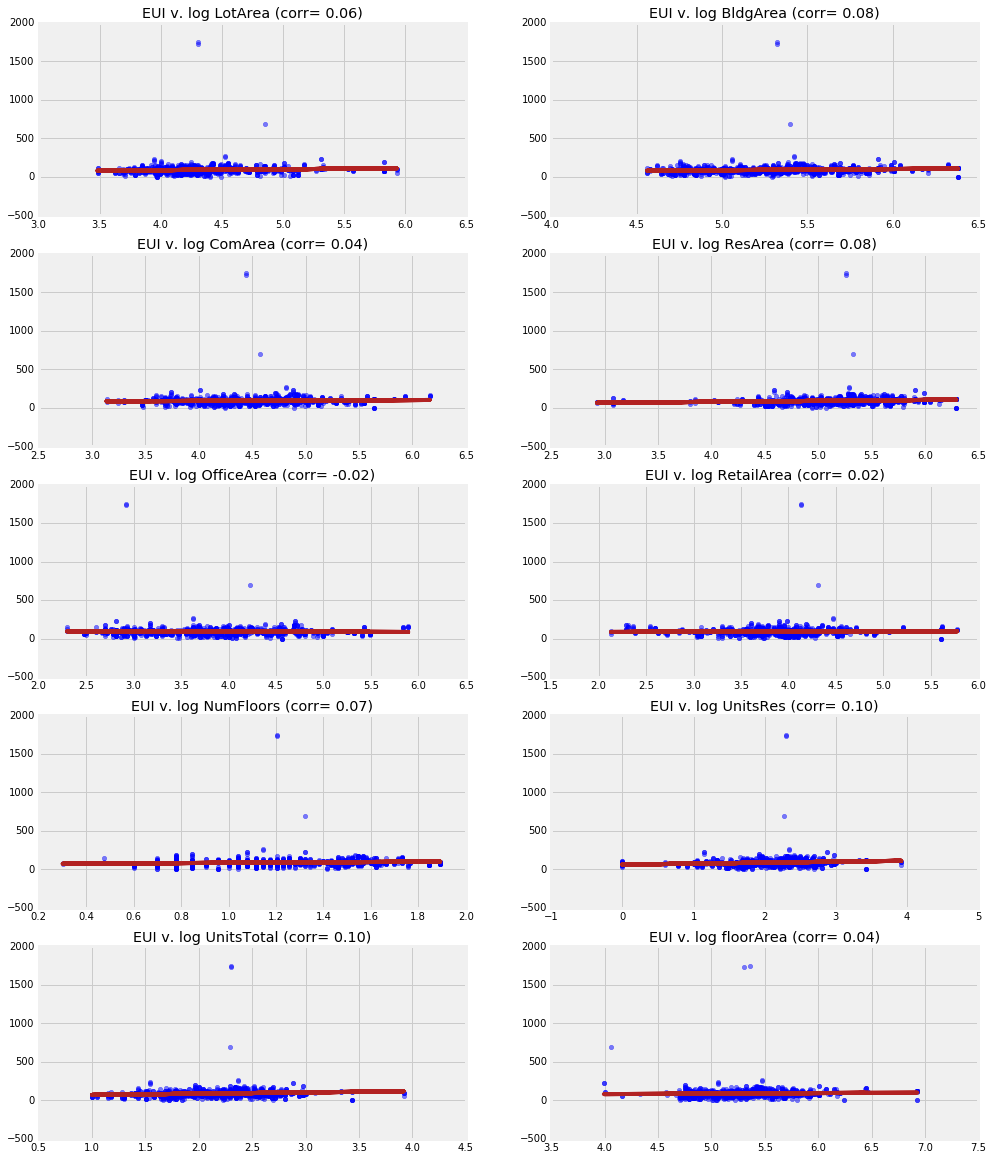

In [76]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(plot_cols + ['floorArea'], 1):
    if not col in df2.columns:
        continue
    plt.subplot(5, 2, i)
    makeCorrPlots(col, 'EUI', df2, log=True)

## Add OLS here....